In [1]:
import matplotlib.pyplot as plt
import os
import gc# from google.colab import files
import glob
import cv2
import numpy as np

In [2]:
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
import torch.utils.data as data
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.cuda.empty_cache()
import gc
gc.collect()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import pandas as pd

In [3]:
torch.manual_seed(42)
device = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
# import splitfolders

In [5]:
# import splitfolders  # or import split_folders

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio("data/train", output="output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

In [6]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/CNS_scratch_1')#tensorboard

In [7]:
torch.cuda.is_available()

True

In [8]:
TRAIN_DATA_PATH = "output"
BATCH_SIZE = 4
EPOCHS = 25
mean = [0.8249, 0.8083, 0.8291]#calculated using the function above
std = [0.1698, 0.1917, 0.1764]#calculated using the fucntion above
# mean = [1.3396, 1.4058, 1.6964]
# std = [1.1032, 1.1746, 1.1060]

In [9]:
# get_mean_and_std(train_iter_loader)

In [10]:
TRANSFORM_IMG_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512,512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
#     transforms.Resize(256),
#     transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
TRANSFORM_IMG_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512,512)),
    # transforms.Resize(256),
    # transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

In [11]:
classes = {'colon': 0,'endometrium_1': 1,'endometrium_2': 2,'kidney': 3,
'liver': 4,'lung': 5,'lymph_node': 6,'pancreas': 7,'skin_1': 8,'skin_2': 9,'small_intestine': 10,'spleen': 11}

In [12]:
class CNSDataset(Dataset):
    def __init__(self,train_or_test,transform):
        self.transform = transform
        self.imgs_path = "output/"+str(train_or_test)+"/"
        file_list = glob.glob(self.imgs_path + "*")
#         print("Folder",file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
#             print("class_names",class_name)
            for img_path in glob.glob(class_path + "/*.tif"):
                self.data.append([img_path, class_name])
#         print(self.data)
        self.class_map = classes
        self.img_dim = (512,512)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
#         norm = np.zeros((224,224))
#         img = cv2.normalize(img,None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)        
        img_tensor = self.transform(img)
        class_id = torch.tensor(class_id)
        return img_tensor, class_id

In [13]:
if __name__ == "__main__":
    dataset = CNSDataset('train',TRANSFORM_IMG_train)
    train_iter_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,generator=torch.Generator(device='cuda'))
    dataset = CNSDataset('val',TRANSFORM_IMG_test)
    test_iter_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,generator=torch.Generator(device='cuda'))

In [14]:
# for i,(image,label) in enumerate(train_iter_loader):
#     print(i,label,image.shape)

In [15]:
# def imshow(img):
#     img = img / 2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg,(1,2,0)))
#     plt.show()

# dataiter = iter(train_iter_loader)
# images, labels = dataiter.next()
# imshow(torchvision.utils.make_grid(images))

# print(' '.join('%s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*125*125,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3  = nn.Linear(84,len(classes))

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*125*125)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
net = CNN()

In [18]:
net.to(device)
net.cuda()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=12, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.0025, momentum=0.9)

start=  torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
accuracy_list = []
best_accuracy = 0
for epoch in range(EPOCHS):
    correct = 0
    total = 0
    gc.collect()
    running_loss = 0.0
    for i, (image,label) in enumerate(train_iter_loader):
        inputs = image.to(device)
        labels = label.to(device)
        optimizer.zero_grad()
        
        img_grid = torchvision.utils.make_grid(inputs)
#         write to tensorboard
#         writer.add_image('CNS_images', img_grid)
#         writer.add_graph(net, inputs)
#         writer.close()

        outputs = net(inputs)
        loss  = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%100 == 99:
            print('[%d, %5d] loss: %.3f' %(epoch + 1,i+1,running_loss/100))
            running_loss=0.0
#             writer.add_scalar("Loss/train", running_loss, epoch)            
        _, predicted = torch.max(outputs.data, 1)

        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print("Epoch:",epoch,'Accuracy:',100*correct/total)
    current_accuracy = 100 * correct/total
    accuracy_list.append(current_accuracy)
    if current_accuracy > best_accuracy:
        model_name = f'model_save/CNS_{int(current_accuracy)}_RA_update.pth'
        torch.save(net.state_dict(), model_name)
        best_accuracy = current_accuracy
    
end.record()

torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))

c:\users\madha\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,   100] loss: 2.466
[1,   200] loss: 2.305
Epoch: 0 Accuracy: 13.125
[2,   100] loss: 2.254
[2,   200] loss: 2.173
Epoch: 1 Accuracy: 17.708333333333332
[3,   100] loss: 2.049
[3,   200] loss: 2.131
Epoch: 2 Accuracy: 22.8125
[4,   100] loss: 2.051
[4,   200] loss: 2.020
Epoch: 3 Accuracy: 23.229166666666668
[5,   100] loss: 1.892
[5,   200] loss: 2.060
Epoch: 4 Accuracy: 26.666666666666668
[6,   100] loss: 1.924
[6,   200] loss: 2.002
Epoch: 5 Accuracy: 26.666666666666668
[7,   100] loss: 1.890
[7,   200] loss: 1.851
Epoch: 6 Accuracy: 29.583333333333332
[8,   100] loss: 1.980
[8,   200] loss: 1.891
Epoch: 7 Accuracy: 27.5
[9,   100] loss: 1.801
[9,   200] loss: 1.830
Epoch: 8 Accuracy: 33.4375
[10,   100] loss: 1.724
[10,   200] loss: 1.820
Epoch: 9 Accuracy: 33.958333333333336
[11,   100] loss: 1.635
[11,   200] loss: 1.869
Epoch: 10 Accuracy: 33.854166666666664
[12,   100] loss: 1.689
[12,   200] loss: 1.765
Epoch: 11 Accuracy: 35.833333333333336
[13,   100] loss: 1.779
[13,   2

In [20]:
df = pd.DataFrame(accuracy_list,columns=['Accuracy'])
df['epochs'] = np.arange(1,len(accuracy_list)+1).astype('int')

Text(0.5, 0, 'Epochs')

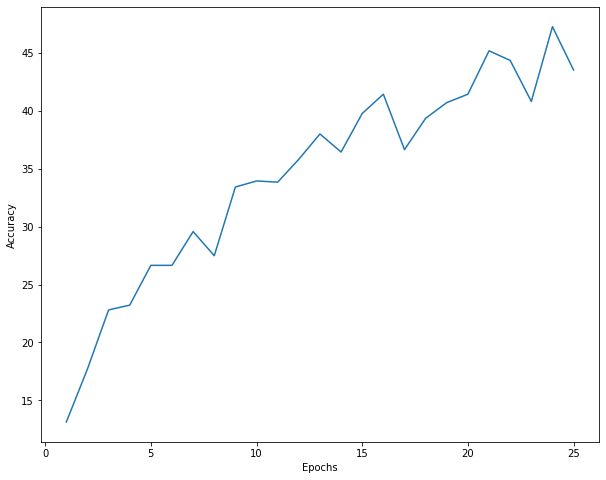

In [21]:
plt.figure(figsize=(10,8))
fig = sns.lineplot(x='epochs',y='Accuracy',data=df)

# fig.set_xticklabels()
fig.set_xlabel('Epochs')

In [22]:
correct = 0
total = 0
actual = []
predicted_list = []
with torch.no_grad():
    for _,(image,label) in enumerate(test_iter_loader):
        images = image.to(device)
        labels = label.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        for i in range(len(predicted)):
            actual.append(labels[i].view(-1).detach().cpu().numpy())
            predicted_list.append(predicted[i].view(-1).detach().cpu().numpy())
#         actual.append(labels)
#         predicted_list.append(predicted)
        print(labels,predicted)
        correct += (predicted == labels).sum().item()
# 
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

tensor([7, 2, 4, 1]) tensor([7, 4, 1, 1])
tensor([7, 2, 7, 1]) tensor([11,  2,  3,  1])
tensor([3, 0, 3, 1]) tensor([9, 0, 4, 4])
tensor([11,  5,  2,  7]) tensor([11,  5,  1,  3])
tensor([8, 7, 0, 5]) tensor([9, 3, 5, 5])
tensor([9, 9, 8, 6]) tensor([9, 9, 8, 2])
tensor([10, 11,  5,  3]) tensor([1, 7, 1, 3])
tensor([6, 9, 3, 5]) tensor([6, 8, 1, 5])
tensor([ 9,  8, 10,  7]) tensor([9, 8, 1, 2])
tensor([ 0,  0, 11,  2]) tensor([10, 10,  4,  2])
tensor([7, 9, 7, 8]) tensor([11,  5,  7,  5])
tensor([ 1, 10,  4,  0]) tensor([ 3, 10,  1,  1])
tensor([ 5, 10,  5,  4]) tensor([5, 1, 5, 2])
tensor([7, 3, 1, 3]) tensor([ 7, 10,  1,  3])
tensor([ 0, 11,  7,  6]) tensor([10, 11,  7,  7])
tensor([ 6, 10,  2,  1]) tensor([7, 1, 2, 1])
tensor([ 6, 11,  8,  1]) tensor([4, 4, 9, 1])
tensor([8, 8, 6, 1]) tensor([5, 8, 7, 1])
tensor([8, 2, 1, 6]) tensor([8, 1, 1, 3])
tensor([ 0,  6, 10, 11]) tensor([ 9,  2,  5, 11])
tensor([ 1,  1,  4, 11]) tensor([2, 1, 4, 4])
tensor([10,  9,  0,  9]) tensor([10,  9, 1

In [23]:
arr = classification_report(np.array(actual), np.array(predicted_list),target_names=classes)

In [24]:
print(arr)

                 precision    recall  f1-score   support

          colon       1.00      0.05      0.10        20
  endometrium_1       0.32      0.50      0.39        20
  endometrium_2       0.36      0.45      0.40        20
         kidney       0.38      0.45      0.41        20
          liver       0.36      0.70      0.47        20
           lung       0.75      0.75      0.75        20
     lymph_node       0.33      0.05      0.09        20
       pancreas       0.35      0.40      0.37        20
         skin_1       0.67      0.50      0.57        20
         skin_2       0.36      0.40      0.38        20
small_intestine       0.35      0.35      0.35        20
         spleen       0.29      0.25      0.27        20

       accuracy                           0.40       240
      macro avg       0.46      0.40      0.38       240
   weighted avg       0.46      0.40      0.38       240



<AxesSubplot:>

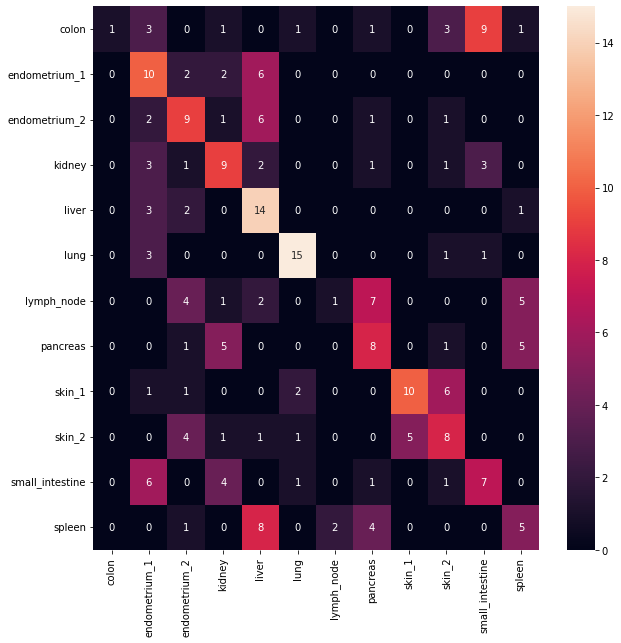

In [25]:
confusion_matrix = confusion_matrix(np.array(actual), np.array(predicted_list))
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(confusion_matrix),annot=True,xticklabels=classes,yticklabels=classes)

In [26]:
# PATH = './CNS_final_scratch.pth'
# torch.save(net.state_dict(), PATH)

In [27]:
# net.load_state_dict(torch.load('CNS_75_RA_scratch_transform_512_trial1.pth'))